In [1]:
import numpy as np
from scipy.cluster.vq import kmeans, vq, whiten
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageDraw

In [2]:
try:
    import google.colab, sys
    !git clone https://github.com/mualal/computer-vision-with-python.git
    sys.path.append('computer-vision-with-python')
    %cd computer-vision-with-python
except:
    import sys
    sys.path.append('..')

In [3]:
import imtools
import pca

# Кластеризация методом K-средних
## Пакет кластеризации в SciPy

In [4]:
class0 = 1.5 * np.random.randn(100, 2)
class1 = np.random.randn(100, 2) + np.array([5, 5])
features = np.vstack((class0, class1))

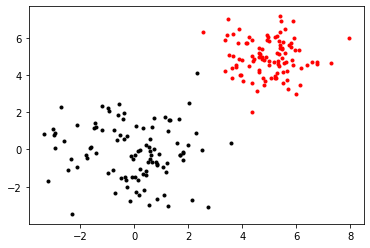

In [5]:
plt.figure()
plt.plot(class0[:,0], class0[:,1], 'k.')
plt.plot(class1[:,0], class1[:,1], 'r.')
plt.show()

In [6]:
centroids, variance = kmeans(features, 2)

In [7]:
code, distance = vq(features, centroids)

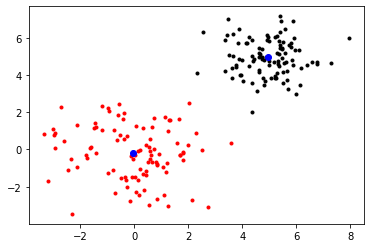

In [8]:
plt.figure()
ndx = np.where(code==0)[0]
plt.plot(features[ndx, 0], features[ndx, 1], 'k.')
ndx = np.where(code==1)[0]
plt.plot(features[ndx, 0], features[ndx, 1], 'r.')
plt.plot(centroids[:, 0], centroids[:, 1], 'bo')
plt.show()

## Кластеризация изображений

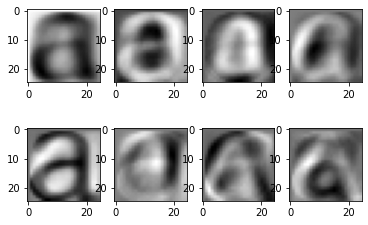

In [9]:
# вычисление некого среднего изображения и главных компонент набора изображений буквы "а" разными шрифтами
imlist = imtools.get_imlist(os.path.join('images_input', 'a_fonts'))

im_example = np.array(Image.open(imlist[0]))
m, n = im_example.shape[0:2]

immatrix = np.array([np.array(Image.open(im)).flatten() for im in imlist], 'f')
v, s, immean = pca.pca(immatrix)

plt.figure()
plt.gray()
plt.subplot(2, 4, 1)
plt.imshow(immean.reshape((m, n)))
for i in range(7):
    plt.subplot(2, 4, i+2)
    plt.imshow(v[i].reshape((m, n)))

In [10]:
imlist = imtools.get_imlist(os.path.join('images_input', 'a_fonts_for_clustering'))

immatrix = np.array([np.array(Image.open(im)).flatten() for im in imlist], 'f')

immean = immean.flatten()
projected = np.array([np.dot(v[:40], immatrix[i] - immean) for i, _ in enumerate(imlist)])

projected = whiten(projected)
centroids, distortion = kmeans(projected, 4)

code, distance = vq(projected, centroids)

Кластер №1


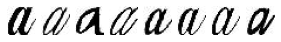

Кластер №2


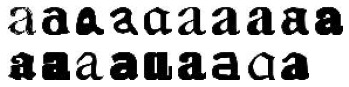

Кластер №3


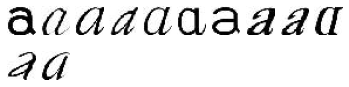

Кластер №4


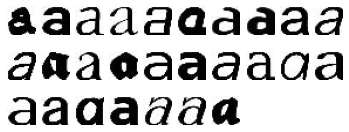

In [11]:
# нанесём кластеры на график
for k in range(4):
    ind = np.where(code == k)[0]
    print(f'Кластер №{k+1}')
    plt.figure()
    plt.gray()
    for i in range(np.minimum(len(ind), 50)):
        plt.subplot(5, 10, i+1)
        plt.imshow(immatrix[ind[i]].reshape((m, n)))
        plt.axis('off')
    plt.show()

## Визуализация проекций изображений на главные компоненты

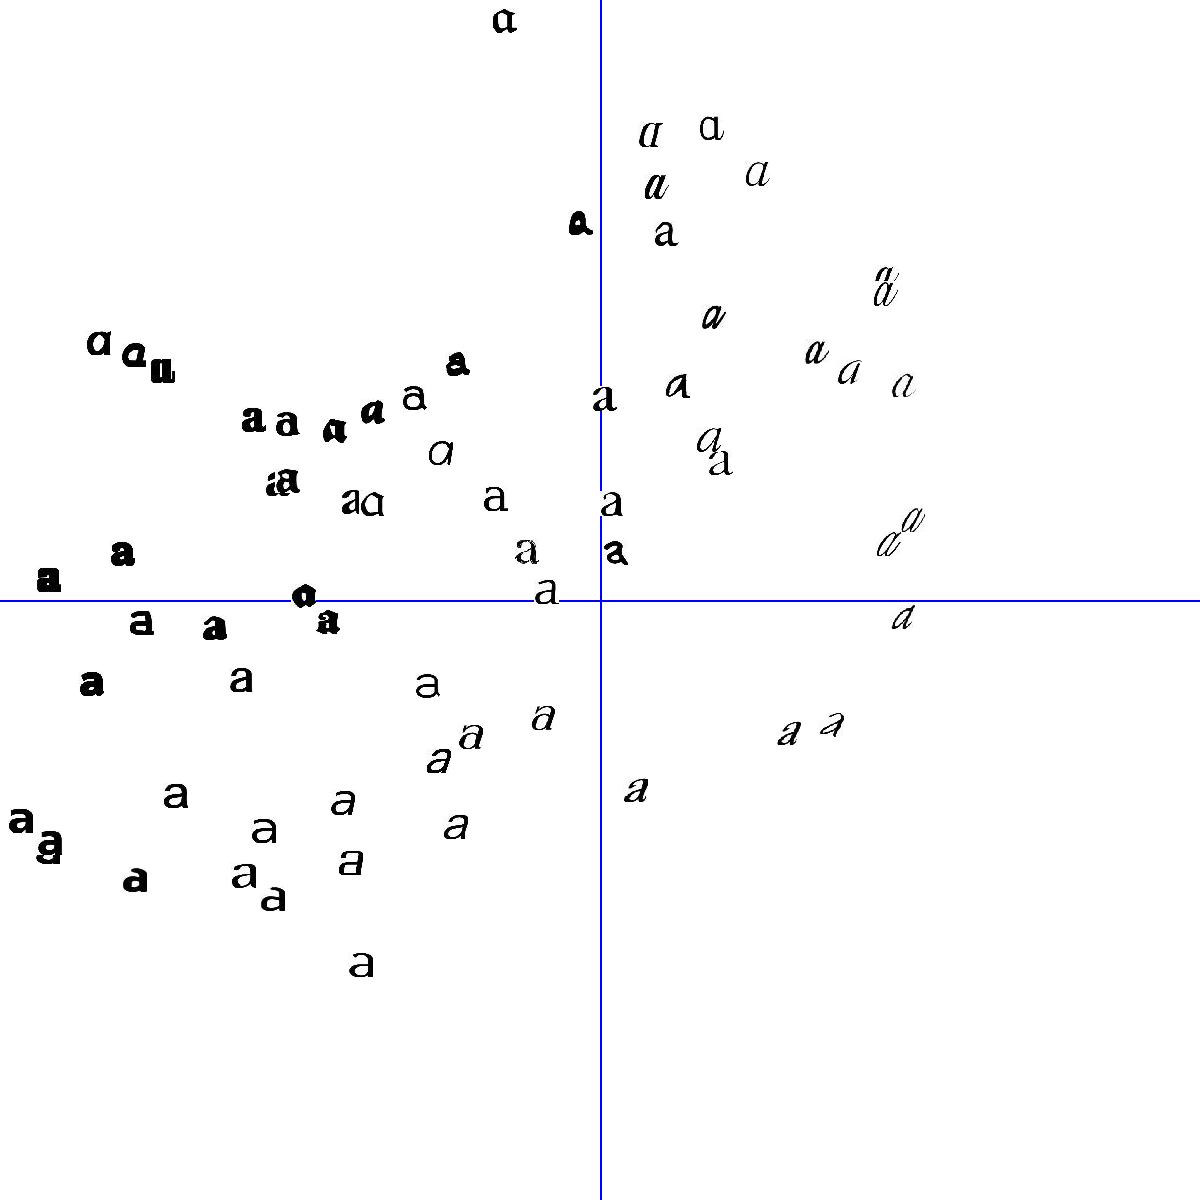

In [12]:
projected = np.array([np.dot(v[[0, 2]], immatrix[i] - immean) for i, _ in enumerate(imlist)])

height, width = 1200, 1200

img = Image.new('RGB', (width, height), (255, 255, 255))
draw = ImageDraw.Draw(img)
draw.line((0, height/2, width, height/2), fill=(0, 0, 255), width=2)
draw.line((width/2, 0, width/2, height), fill=(0, 0, 255), width=2)
scale = np.abs(projected).max(0)
scaled = np.floor(
    np.array(
        [(p / scale) * (width / 2 - 20, height / 2 - 20) + (width / 2, height / 2) for p in projected]
    )
).astype(int)

for i, _ in enumerate(imlist):
    nodeim = Image.open(imlist[i])
    nodeim.thumbnail((m, n))
    ns = nodeim.size
    img.paste(
        nodeim,
        (scaled[i][0] - ns[0] // 2, scaled[i][1] - ns[1] // 2, scaled[i][0] + ns[0] // 2 + 1, scaled[i][1] + ns[1] // 2 + 1)
    )
img.save(os.path.join('images_output', 'pca_font.jpg'))
img

## Кластеризация пикселей

# Иерархическая кластеризация

# Спектральная кластеризация